In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
#from torchvision.datasets import MNIST

In [5]:
print(torch.__version__)

1.6.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
#import os
#os.chdir("/content/drive/My Drive") 
import ra
#import complexLayers


In [19]:
dataset = ra.read('atomsroa.ra')
train_data = torch.tensor(dataset)

In [20]:
train_data = train_data.imag
train_data =  torch.transpose(train_data, 0, 1)

In [21]:
labelset = ra.read('paramsroa.ra')
train_label1 = torch.tensor(labelset)

In [22]:
dataset1 = ra.read('atoms.ra')
traindata1 = torch.tensor(dataset1)
traindata1 = traindata1.imag
traindata1 =  torch.transpose(traindata1, 0, 1)
label1 = ra.read('params.ra')
label1 = torch.tensor(label1)

In [18]:
print(traindata1)
print(train_data)

tensor([[[ 0.0038,  0.0015, -0.0007,  ..., -0.0274, -0.0272, -0.0269]],

        [[ 0.0045,  0.0023,  0.0001,  ..., -0.0279, -0.0276, -0.0273]],

        [[ 0.0052,  0.0031,  0.0010,  ..., -0.0283, -0.0280, -0.0278]],

        ...,

        [[ 0.0215,  0.0229,  0.0242,  ..., -0.0250, -0.0246, -0.0243]],

        [[ 0.0216,  0.0230,  0.0243,  ..., -0.0250, -0.0246, -0.0243]],

        [[ 0.0216,  0.0230,  0.0243,  ..., -0.0250, -0.0247, -0.0243]]],
       dtype=torch.float64)
tensor([[[-0.0100, -0.0114, -0.0094,  ...,  0.0324,  0.0322,  0.0320]],

        [[-0.0105, -0.0123, -0.0106,  ...,  0.0329,  0.0327,  0.0325]],

        [[-0.0110, -0.0132, -0.0117,  ...,  0.0333,  0.0331,  0.0330]],

        ...,

        [[-0.0141, -0.0290, -0.0443,  ...,  0.0006,  0.0012,  0.0019]],

        [[-0.0141, -0.0290, -0.0443,  ...,  0.0006,  0.0012,  0.0019]],

        [[-0.0141, -0.0289, -0.0443,  ...,  0.0006,  0.0012,  0.0019]]],
       dtype=torch.float64)


In [23]:
print(traindata1.shape)
train_data.shape

torch.Size([108056, 1000])


torch.Size([108056, 1000])

In [24]:
alldata = torch.cat((train_data,traindata1),0)

In [25]:
alldata.shape

torch.Size([216112, 1000])

In [26]:
labels1 = torch.cat((train_label1[1,:],label1[1,:]),0)

In [10]:
print(labels1)
print(labels1.shape)
print(train_label1.shape)

tensor([[ 100.,  110.,  120.,  ..., 3980., 3990., 4000.],
        [  20.,   20.,   20.,  ..., 2000., 2000., 2000.]], dtype=torch.float64)
torch.Size([2, 216112])
torch.Size([3, 108056])


In [27]:
labels1 = torch.transpose(labels1, 0, 1)
print(labels1.shape)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [28]:
import torch.utils.data as data
train_dataset = data.TensorDataset(alldata,labels1)

In [ ]:
from sklearn.decomposition import PCA
X_reduced = PCA(n_components=10).fit_transform(train_data)

In [ ]:
pca = PCA(n_components=10)
pca.fit(train_data)

print(pca.explained_variance_ratio_.shape)
print(pca.components_.shape)
print(pca.singular_values_.shape)
print(pca.mean_.shape)

In [ ]:
train_data = torch.tensor(X_reduced)

In [29]:
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [140000, 60000 ,16112])

We found that the network model with smallest
average error for validation data consists of 3 convolutional layers (kernel size = 3, stride
size = 2), each followed by a rectified linear unit (ReLU) activation function. The number
of the feature maps per convolutional layer is increasing, from 32 in the first to 128 in
the last. After convolution an average pooling layer follows with the same size as the
stride size. The last layer is fully connected, with 2 outputs. 

In [30]:

def _batch_norm(x):
  eps_ = torch.finfo(torch.float32).eps
  y = (x - torch.mean(x)) / (torch.std(x) + eps_)
  return y


# define baseline model
class BaselineModel1(nn.Module):
    def __init__(self):
        super(BaselineModel1, self).__init__()
        self.fc1 = nn.Linear(1000, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)


    def forward(self, x):
        #print(x)
        out = self.fc1(x)
        #print(out)
        #raise error
        out = _batch_norm(out)
        #out = self.bn(512)
        out = torch.sigmoid(out)
        out = self.fc2(out)
        #out = self.bn(256)
        out = _batch_norm(out)
        out = torch.sigmoid(out)
        out = self.fc3(out)
        return out

In [31]:
N = 200
val_loss = list()
#val_accu = list()
train_loss = list()
#train_accu = list()

In [32]:
#assert torch.cuda.is_available()
device1 = "cuda:0" if torch.cuda.is_available() else "cpu"
#cuda_device = torch.device("cuda")
seed = 7
torch.manual_seed(seed)
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

def loss_batch(model, loss_func, xb, yb, opt=None):
    outputs = model(xb.float())
    yb = yb.float()
    outputs = torch.squeeze(outputs, 1)
    loss = loss_func(outputs, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [ ]:
!pip install pycuda
import torch
import pycuda.driver as cuda
cuda.init()
## Get Id of default device
torch.cuda.current_device()
# 0
cuda.Device(0).name() # '0' is the id of your GPU

In [33]:

# build the model
model = BaselineModel1().to(device1)

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())

# the epoch loop
for epoch in range(N):
    model.train()
    running_loss = 0.0
    loss=0
    for data in trainloader:
        # get the inputs
        inputs, labels = data
        #inputs = inputs.unsqueeze(1).unsqueeze(-1)
        #inputs = inputs.unsqueeze(1)
        #inputs = torch.unsqueeze(inputs1, 2)

        inputs, labels = inputs.to(device1), labels.to(device1)
        
        
        loss, nums = loss_batch(model, loss_function, inputs.float(), labels.float(), optimiser)
        running_loss += loss
    train_loss.append(loss)

    model.eval()
    with torch.no_grad():
        losses, nums = zip(
                *[loss_batch(model.to(device1), loss_function, xb.to(device1), yb.to(device1)) for xb, yb in validloader]
            )
        val_loss1 = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_loss.append(val_loss1)


        #print(epoch, val_loss)

        
        # keep track of the loss this epoch
        #running_loss += loss.item()
    print("Epoch %d, loss %4.2f" % (epoch, running_loss))
print('**** Finished Training ****')

Epoch 0, loss 1063633684.06
Epoch 1, loss 776429143.66
Epoch 2, loss 550152499.00
Epoch 3, loss 373218831.92
Epoch 4, loss 239406754.81
Epoch 5, loss 144220809.29
Epoch 6, loss 82401625.01
Epoch 7, loss 48221081.47
Epoch 8, loss 33940481.20
Epoch 9, loss 30064326.36
Epoch 10, loss 29498634.47
Epoch 11, loss 29311963.59
Epoch 12, loss 29047198.61
Epoch 13, loss 29086444.41
Epoch 14, loss 28849437.54
Epoch 15, loss 28805068.68
Epoch 16, loss 28542516.67
Epoch 17, loss 28510076.79
Epoch 18, loss 28320560.88
Epoch 19, loss 28355514.89
Epoch 20, loss 28165767.30
Epoch 21, loss 28127279.58
Epoch 22, loss 27966549.52
Epoch 23, loss 27799266.10
Epoch 24, loss 27882287.18
Epoch 25, loss 27514654.81
Epoch 26, loss 27392526.69
Epoch 27, loss 27429929.00
Epoch 28, loss 27299159.21
Epoch 29, loss 27181552.25
Epoch 30, loss 26863877.14
Epoch 31, loss 26747442.70
Epoch 32, loss 26810683.98
Epoch 33, loss 26377458.91
Epoch 34, loss 26417691.37
Epoch 35, loss 26176936.64
Epoch 36, loss 26016111.68
Epoc

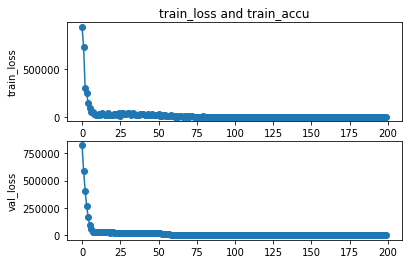

In [34]:
import matplotlib.pyplot as plt

x = range(0, N)
y1 = train_loss
#y2 = train_accu
y3 = val_loss
#y4 = val_accu
plt.subplot(2, 1, 1)
plt.plot(x, y1, 'o-')
plt.title('train_loss and train_accu')
plt.ylabel('train_loss')
#plt.subplot(2, 1, 2)
#plt.plot(x, y2, '.-')
#plt.xlabel('epoches')
#plt.ylabel('train_accu')
plt.subplot(2, 1, 2)
plt.plot(x, y3, 'o-')
plt.ylabel('val_loss')
#plt.subplot(2, 2, 2)
#plt.plot(x, y4, '.-')
#plt.title('val_loss and val_accu')
#lt.ylabel('val_accu')
plt.show()
#plt.savefig("accuracy_loss.jpg")


In [39]:
print(y1)

[948837.375, 737496.4375, 300314.3125, 249863.6875, 141382.8125, 92907.53125, 47564.234375, 53716.32421875, 23620.24609375, 13410.642578125, 23277.005859375, 23941.115234375, 21689.72265625, 37892.0859375, 28869.48046875, 22976.765625, 17514.44140625, 37710.05078125, 22292.529296875, 20539.140625, 20477.482421875, 29888.802734375, 26686.474609375, 21447.16796875, 37562.828125, 9631.0927734375, 34180.35546875, 36219.78125, 25753.82421875, 27967.904296875, 42836.2421875, 35549.140625, 15520.9296875, 34535.453125, 29130.826171875, 16920.09765625, 16520.53125, 20457.2421875, 24146.9296875, 32421.234375, 23507.333984375, 13511.8623046875, 19094.205078125, 23936.93359375, 23000.68359375, 16268.2734375, 30808.8203125, 20638.17578125, 13133.548828125, 19343.884765625, 25071.62109375, 10162.1044921875, 11597.107421875, 22770.63671875, 21621.08203125, 9761.072265625, 11871.828125, 11941.1748046875, 15812.9794921875, 6320.5498046875, 6070.7060546875, 1911.7908935546875, 6366.56201171875, 1004.219

In [40]:
val_loss

[821898.1128333333,
 591769.3713666666,
 409491.20043333335,
 269276.31413333333,
 166449.72080833334,
 96423.94970833333,
 54419.39523958333,
 34383.08385625,
 27921.86628125,
 26760.792785416666,
 26594.471002083334,
 26585.85334375,
 26531.725408333332,
 26441.1937125,
 26289.1452125,
 26087.707351041667,
 26231.91206458333,
 25860.189727083332,
 25729.45141875,
 25804.785923958334,
 25811.931954166666,
 25468.31189375,
 25319.517859375,
 25211.816152083335,
 25253.73783125,
 24998.042992708335,
 24902.603040625,
 24816.623779166668,
 24652.51254375,
 24611.034104166665,
 24809.5839375,
 24300.313522916666,
 24403.05160625,
 23975.901715625,
 24282.182483333334,
 23690.974402083335,
 23534.22950625,
 23658.385054166665,
 23176.874029166665,
 22940.474710416667,
 22670.54675625,
 22393.017033333334,
 22141.559059375,
 21903.665772916665,
 21525.470208333332,
 21117.311383333334,
 20429.93850416667,
 19844.079425,
 19220.862169791668,
 18480.748127083334,
 17584.56591875,
 16841.32427

In [38]:
print(y3)

[703.6233526871955, 705.4232637770955, 712.7745493762898, 710.7798474339293, 707.5043044028713, 705.5398178933985, 709.9524716147126, 714.5519250985291, 725.7138992506556, 716.5729119188144, 716.330728116078, 717.127453528426, 707.65085032822, 716.2235803234778, 701.0062400719379, 712.489923986683, 705.7688030708866, 708.3502433345003, 719.9569242111858, 709.0463776877289, 716.284014947128, 710.8139443572725, 707.5057217883023, 709.5279620112824, 718.6374150477905, 704.5407191165746, 714.3424210458431, 721.2749254971062, 702.1778340798977, 706.9759413293954, 711.9852553124224, 702.8039194995384, 703.506821542416, 732.5228194508558, 704.2695111271878, 706.4093598836465, 709.4324771157561, 708.5556326054532, 716.7781543902157, 720.2270923603137, 715.4021307633674, 701.4327241050925, 711.7449467497052, 703.8753276624178, 718.0356724122548, 708.2125872675451, 701.1885638421674, 699.9334933480771, 710.6647273407438, 706.6938215935716, 709.6927050199386, 709.5207806826821, 701.50382842563, 7

In [21]:
model.eval()

BaselineModel1(
  (fc1): Linear(in_features=1000, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)

In [35]:
model.eval()
test_loss = list()
for data in testloader:
    losses, nums = zip(
                *[loss_batch(model.to(device1), loss_function, xb.to(device1), yb.to(device1)) for xb, yb in testloader])
    test_loss1 = np.sum(np.multiply(losses, nums)) / np.sum(nums)
    test_loss.append(test_loss1)

In [36]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'test_loss')

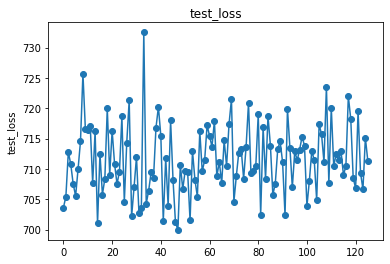

In [37]:
x = range(0, 126)
y3 = test_loss
plt.plot(x, y3, 'o-')
plt.title('test_loss')
plt.ylabel('test_loss')

In [ ]:
for data in testloader:
    inputs, lablels = data
    predictions = model(inputs.float())
    loss = loss_function(predictions,labels)
    loss = loss/128
    print("loss",loss)
    print("predicted parameter:", predictions)
    print("setting parameter:", labels)

In [ ]:
testdataset = ra.read('atomsroa.ra')
testdata = torch.tensor(testdataset)
testdata = testdata.imag
label1 = ra.read('paramsroa.ra')
label1 = torch.tensor(label1)

In [ ]:
for i in range(8056):
    inputs = testdata[:,i]
    lablels = label1[0,i]
    predictions = model(inputs.float())

    print("predicted parameter:", predictions)
    print("setting parameter:", lablels)

## Saving models

Being able to train a model is fine, but in practice once we've trained the model we probably want to save the result so we can reuse it at a later time. PyTorch makes saving the model easy using the torch.save(state, filepath) function. This will save the weights of the model so they can be loaded into a new instance at a later point.

Run the following code to save the weights for use in the next part of the lab.

In [17]:
#save the trained model weights
torch.save(model.state_dict(), "./BaselineModel1.weights")

If you are running on Colab, run the following to download the weights to the local machine:

In [ ]:
from google.colab import files
files.download('BaselineModel.weights')

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = BaselineModel(1000, 512, 256).to(device)
model.load_state_dict(torch.load('BaselineModel.weights'))